# Inverse Fourier Transform Calculation
This jupyter notebook will show the demonstration about how to construct a inverse FFT algorithm via Pytorch AutoGrad, hope this can help you in your future research!

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scienceplots
from matplotlib.ticker import MaxNLocator
from tqdm.notebook import tqdm
import torch.nn.functional as func
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['KMP_DUPLICATE_LIB_OK']='True'

##  Display the GPU ussage
from GPUtil import showUtilization as gpu_usage
gpu_usage()         

| ID | GPU | MEM |
------------------
|  0 |  5% | 45% |


## Select Device
In pytorch, we can mnually select the devive we want to use to do the calculation. Make sure your own laptop or local device has NVIDIA GPU and CUDA supported.

In [43]:
DEVICE = 'cuda' ## cuda | cpu
Nor = 1         ## The total energy

## Define the useful function

In [44]:
def Imaging(Input_phase, device=DEVICE):
    """
    Computes the FFT-based imaging of an input phase array.

    Parameters:
    - Input_phase (torch.Tensor): A 2D tensor representing the phase input. The shape of the tensor should be (DimX, DimY).
    - device (str or torch.device, optional): The device on which to perform the computation, such as 'cpu' or 'cuda'. 
      Default is set to the global DEVICE variable.

    Returns:
    - Output_field (torch.Tensor): A 2D tensor representing the intensity output field after FFT-based imaging.

    Description:
    This function takes an input phase tensor, computes the corresponding input field in the Fourier domain using FFT, 
    shifts the zero frequency component to the center, and then computes the intensity of the resulting field. The 
    output is the squared magnitude of the field multiplied by a normalization factor 'Nor'.
    """
    # Set the device for the computation
    device = torch.device(device)
    Input_phase = Input_phase.to(device)
    DimX, DimY = Input_phase.shape

    # Compute the input field
    Input_field = 1 / (DimX * DimY) * torch.exp(1j * Input_phase)
    
    # Compute the output field by applying FFT, shifting, and squaring
    Output_field = abs(torch.fft.fftshift(torch.fft.fftn(Input_field))) ** 2 * Nor
    
    return Output_field


def random_tensor(x, y, device=DEVICE):
    """
    Generates a random tensor of size (x, y) with values in the range [0, 1].

    Parameters:
    - x (int): The number of rows for the tensor.
    - y (int): The number of columns for the tensor.
    - device (str or torch.device, optional): The device on which to create the tensor, such as 'cpu' or 'cuda'. 
      Default is set to the global DEVICE variable.

    Returns:
    - tensor (torch.Tensor): A tensor of shape (x, y) with random float values between 0 and 1, allocated on the specified device.

    Description:
    This function creates a 2D tensor with dimensions (x, y), filled with random float values uniformly distributed 
    between 0 and 1. The tensor is created on the specified device (CPU or GPU).
    """
    # Set the device for the tensor computation
    device = torch.device(device)
    
    # Generate a random tensor with values between 0 and 1
    tensor = torch.rand(x, y, dtype=torch.float32, device=device)
    
    return tensor


def To_Phase(Input, device=DEVICE):
    """
    Converts an input tensor to a phase tensor using a cosine transformation.

    Parameters:
    - Input (torch.Tensor): The input tensor containing values to be transformed to phases.
    - device (str or torch.device, optional): The device on which to perform the computation, such as 'cpu' or 'cuda'.
      Default is set to the global DEVICE variable.

    Returns:
    - Output (torch.Tensor): A tensor of phase values in the range [0, 2π] allocated on the specified device.

    Description:
    This function transforms an input tensor by applying a cosine function and scaling it to the range [0, 2π]. 
    The resulting tensor represents phase values, which are suitable for use in phase-related computations.
    """
    # Set the device for the computation
    device = torch.device(device)
    
    # Compute the output phase tensor
    Output = (torch.cos(Input)) * torch.pi + torch.pi
    
    return Output


def Read_target(filepath, filename, x, y):
    """
    Reads and processes a target image, converting it to a binary format and normalizing it.

    Parameters:
    - filepath (str): The path to the directory containing the target image.
    - filename (str): The name of the image file to be read.
    - x (int): The desired width of the resized image.
    - y (int): The desired height of the resized image.

    Returns:
    - target (torch.Tensor): A normalized tensor representation of the processed target image.

    Description:
    This function reads an image from the specified filepath and filename, resizes it to the given dimensions, 
    and applies a binary threshold to create a binary image. The binary image is then normalized, 
    converted into a PyTorch tensor, and returned. The normalization ensures the sum of all elements in the tensor 
    is scaled by a factor defined by `Nor`.
    """
    # Store the current working directory
    original_dir = os.getcwd()

    try:
        # Change the working directory to the specified filepath
        os.chdir(filepath)
        
        # Read the target image in grayscale
        target = cv2.imread(filename, 0)
        
        # Resize the image to the specified dimensions
        target = cv2.resize(target, (x, y))

        # Apply binary threshold using Otsu's method
        thr, binary = cv2.threshold(target, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Find contours in the binary image
        contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # Normalize binary image to [0, 1] and adjust zero values to 0.05
        target = binary[:, :] / 255
        target[np.where(target == 0)] = 0.05

        # Convert to PyTorch tensor and normalize
        target = torch.tensor(target, dtype=torch.float32).to(device=DEVICE)
        target = target / torch.sum(target) * Nor

    finally:
        # Change back to the original working directory
        os.chdir(original_dir)
    
    return target


def circle(masksize, radius, device=DEVICE):
    """
    Generates a circular mask tensor.

    Parameters:
    - masksize (int): The size of the mask (both width and height).
    - radius (float): The radius of the circle in pixels.
    - device (str or torch.device, optional): The device to perform the computation on (e.g., 'cpu' or 'cuda').

    Returns:
    - torch.Tensor: A mask tensor of shape (masksize, masksize) where pixels within the specified radius are 1, and all others are 0.

    Description:
    This function creates a square mask of the specified size with a filled circle of the given radius at its center. 
    The circle is generated using the Euclidean distance formula, and values within the specified radius are set to 1, 
    while others are set to 0.
    """
    # Set the computation device
    device = torch.device(device)
    
    # Create a meshgrid for the x and y coordinates
    x, y = torch.meshgrid(torch.arange(masksize, device=device), torch.arange(masksize, device=device))
    
    # Calculate the center of the mask
    center = masksize // 2
    
    # Compute the Euclidean distance from each point to the center
    distance = ((x - center) ** 2 + (y - center) ** 2).sqrt()
    
    # Return a mask with 1s inside the circle and 0s outside
    return (distance <= radius).float()


def Show_Image(Phase_mask, initial_FFT, Target):
    """
    Displays the phase mask, FFT image, and target image side-by-side using matplotlib.

    Parameters:
    - Phase_mask (torch.Tensor): The phase mask tensor to be visualized.
    - initial_FFT (torch.Tensor): The FFT image tensor to be visualized.
    - Target (torch.Tensor): The target image tensor to be visualized.

    Description:
    This function creates a figure with three subplots to display the phase mask, FFT image, 
    and target image. Each subplot includes a colorbar for reference. The function handles 
    both regular and detached tensors and visualizes them using the 'viridis' colormap.

    """
    # Create a figure and a 1x3 grid of subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    try:
        # Display Phase Mask
        axs[0].set_title('Phase Mask', fontsize=24)
        im0 = axs[0].imshow(Phase_mask.cpu().numpy(), cmap='viridis')
        plt.colorbar(im0, ax=axs[0], shrink=0.75)

        # Display FFT Image
        axs[1].set_title('FFT Image', fontsize=24)
        im1 = axs[1].imshow(initial_FFT.cpu().numpy(), cmap='viridis')
        plt.colorbar(im1, ax=axs[1], shrink=0.75)

        # Display Target Image
        axs[2].set_title('Target', fontsize=24)
        im2 = axs[2].imshow(Target.cpu().numpy(), cmap='viridis')
        plt.colorbar(im2, ax=axs[2], shrink=0.75)

    except:
        # Fallback for detached tensors
        axs[0].set_title('Phase Mask', fontsize=24)
        im0 = axs[0].imshow(Phase_mask.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar(im0, ax=axs[0], shrink=0.75)

        axs[1].set_title('FFT Image', fontsize=24)
        im1 = axs[1].imshow(initial_FFT.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar(im1, ax=axs[1], shrink=0.75)

        axs[2].set_title('Target', fontsize=24)
        im2 = axs[2].imshow(Target.cpu().detach().numpy(), cmap='viridis')
        plt.colorbar(im2, ax=axs[2], shrink=0.75)

    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the figure
    plt.show()


def set_seed(seed=42):
    """
    Set the seed for random number generation to ensure reproducibility.

    Parameters:
    - seed (int): The seed value to be set. Default is 42.
    """
    # Set the seed for NumPy random number generation
    np.random.seed(seed)
    
    # Set the seed for PyTorch random number generation (CPU)
    torch.manual_seed(seed)
    
    # Set the seed for PyTorch random number generation (GPU) if available
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
    
    # Ensure deterministic behavior in PyTorch
    torch.backends.cudnn.benchmark = False  # Disable the CuDNN auto-tuner
    torch.backends.cudnn.deterministic = True  # Use deterministic algorithms

def Show_train_process(Loss):
    B = 2

    fig, axes = plt.subplots(figsize = (4,4))
    axes.yaxis.set_major_locator(MaxNLocator(4)) 
    axes.xaxis.set_major_locator(MaxNLocator(4))    

    TK = plt.gca()
    TK.spines['bottom'].set_linewidth(B)
    TK.spines['top'].set_linewidth(B)
    TK.spines['right'].set_linewidth(B)
    TK.spines['left'].set_linewidth(B)
    plt.tick_params(which = 'major', width = B, length = 8)
    plt.tick_params(which = 'minor', width = B, length = 5)

    axes.tick_params(axis="x", labelsize=14)
    axes.tick_params(axis="y", labelsize=14)

    axes.set_xlabel('Iterations', fontsize = 16)
    axes.set_ylabel('Cost Energy', fontsize = 16)

    plt.title('Cost Function Loss', fontsize = 24)
    plt.plot(Loss[:], 'r-', linewidth = 2)

## Initialization
In this part, we will do the initial parameters setting and see the results of FFT imaging without inverse optimization

In [45]:
## Parameter Set Up ==> Unit = nm
x, y = 81, 81

## Define Initial Phase Mask
Initial_phase = To_Phase(random_tensor(x, y))
Image = Imaging(Initial_phase)

## Read Target Image
file_path = r".\Target"
target = Read_target(file_path, 'P.png', x, y)

### Show result

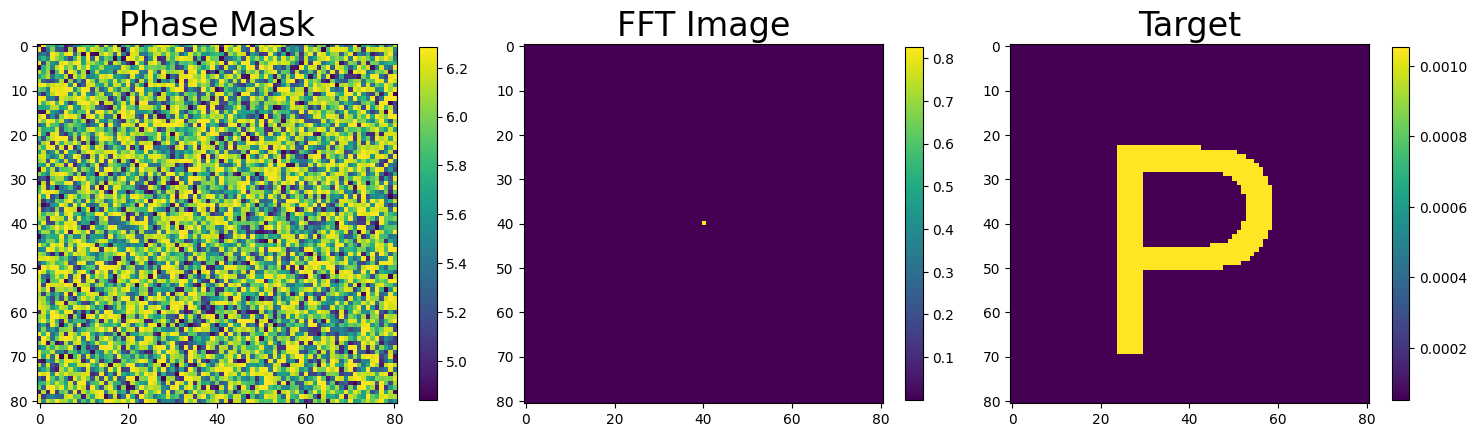

In [46]:
Show_Image(Initial_phase, Image, target)

## Inverse FFT Main Code 

### Define Model

In [47]:
def Model(Input_phase, device = DEVICE):
    # Set the device for the computation
    device = torch.device(device)
    Input_phase = Input_phase.to(device)
    DimX, DimY = Input_phase.shape

    Input_field = 1/(DimX * DimY) * torch.exp(1j*Input_phase)

    ## Field
    Output_field = torch.fft.fftshift(torch.fft.fftn(Input_field)) * Nor
    
    return Output_field

# Define the contrast function
def contrast_function(image):
    mean_intensity = torch.mean(image)
    contrast = torch.sqrt(torch.mean((image - mean_intensity) ** 2))
    return contrast

# Define the smoothness function
def smoothness_function(image):
    diff_x = torch.abs(image[:, 1:] - image[:, :-1])
    diff_y = torch.abs(image[1:, :] - image[:-1, :])
    smoothness_loss = torch.sum(diff_x) + torch.sum(diff_y)
    return smoothness_loss

# Loss Function
def loss_fn(Input, Target, Approach = 'Intensity', Dynamic = False, Loss_threshold = None, Scale_factor = None, Extra_loss = False): 
    # Get Amplitude ,Phase and Intensity from Input Field
    Input_amp = torch.abs(Input)
    Input_phase = torch.angle(Input)
    Input_intensity = Input_amp**2
    
    # Get Amplitude and Phase from Target
    Target_amp = abs(torch.sqrt(Target))
    Target_phase = torch.zeros_like(Target)
    Target_phase[torch.where(Target == torch.min(Target))] = torch.pi

    ## Difference
    # Calculate the amplitude difference
    Amplitude_diff = abs(Target_amp - Input_amp) ** 2

    # Calculate the phase difference
    Phase_diff = torch.abs(abs(Input_phase) - Target_phase)

    # Calculate the intensity difference
    Intensity_diff = abs(Target - Input_intensity) ** 2

    if Dynamic == True:
        loss_max = torch.max(Intensity_diff.clone())
        if loss_max  <=  Loss_threshold :
            scale = Scale_factor
            Intensity_diff *= scale
    
    contrast_loss = 0
    smoothness_loss = 0

    if Extra_loss == True:
        # Compute the contrast loss
        input_contrast = contrast_function(Input_intensity)
        target_contrast = contrast_function(Target)
        contrast_loss += torch.abs(input_contrast - target_contrast)
        
        # Compute the smoothness loss
        smoothness_loss += smoothness_function(Input_intensity)

    ### Loss
    Amplitude_loss = Amplitude_diff.sum()
    Phase_loss = Phase_diff.mean()
    Intensity_loss = Intensity_diff.sum()

    # Total loss (you can adjust the weight of contrast_loss and smoothness_loss if necessary)
    Extra_LOSS = contrast_loss + smoothness_loss

    if Approach == 'Intensity':
        total_loss = Intensity_loss + Extra_LOSS
    if Approach == 'Amplitude':
        total_loss = Amplitude_loss + Extra_LOSS
    if Approach == 'Field':
        total_loss = Amplitude_loss + Phase_loss + Extra_LOSS
    
    return total_loss

### Define Training Loop

In [48]:
import torch.nn.functional as func

def training_loop(n_epochs, optimizer, Params, Target, APPROACH, DYNAMIC, LOSSTHRESHOLD, SCALEFACTOR, EXTRALOSS):
    Loss = []
    for epoch in tqdm(range(1, n_epochs + 1)):
        Input_phase = To_Phase(Params)
        current_field = Model(Input_phase) 
        loss = loss_fn(current_field, 
                       Target, 
                       Approach = APPROACH, 
                       Dynamic = DYNAMIC, 
                       Loss_threshold = LOSSTHRESHOLD, 
                       Scale_factor = SCALEFACTOR, 
                       Extra_loss = EXTRALOSS)

        ## Calculate and Upgrade the gradient automatically
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        Input_intensity = abs(current_field)**2
        Intensity_diff = abs(Target - Input_intensity)**2
        LOSS = Intensity_diff.sum()

        if epoch == 1:
            # initial = loss.cpu().detach().numpy()
            initial = LOSS.cpu().detach().numpy()
            print('Initial Cost = ', initial)

        if epoch == n_epochs:
            # final = loss.cpu().detach().numpy()
            final = LOSS.cpu().detach().numpy()
            print('Final Cost = ', final)
            print('Cost Improvement = ', (initial - final)/initial * 100, '%')
            
        # Loss.append(loss.cpu().detach().numpy()/initial)
        Loss.append(LOSS.cpu().detach().numpy()/initial)
    return Params, Loss

### Import and show the selectable optimization algorithm

In [49]:
import torch.optim as optim
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

### Start Training

In [68]:
set_seed()

Initial = random_tensor(x, y, device = DEVICE)
params = Initial.clone().detach().requires_grad_(True)

learning_rate = 0.1

optimizer = optim.Adam([params], lr=learning_rate)

final_Adam, Loss_Adam = training_loop(n_epochs = 500, 
              optimizer = optimizer,
              Params = params, 
              Target = target,
              APPROACH = 'Field',
              DYNAMIC = False,
              LOSSTHRESHOLD = None,
              SCALEFACTOR = None,
              EXTRALOSS = False)

  0%|          | 0/500 [00:00<?, ?it/s]

Initial Cost =  0.6788065
Final Cost =  0.0005354637
Cost Improvement =  99.92111325263977 %


# Show Results After Inverse FFT

### Training Process

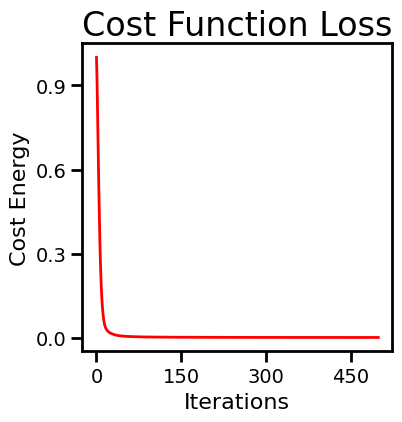

In [69]:
Show_train_process(Loss_Adam)

### Calculated Result

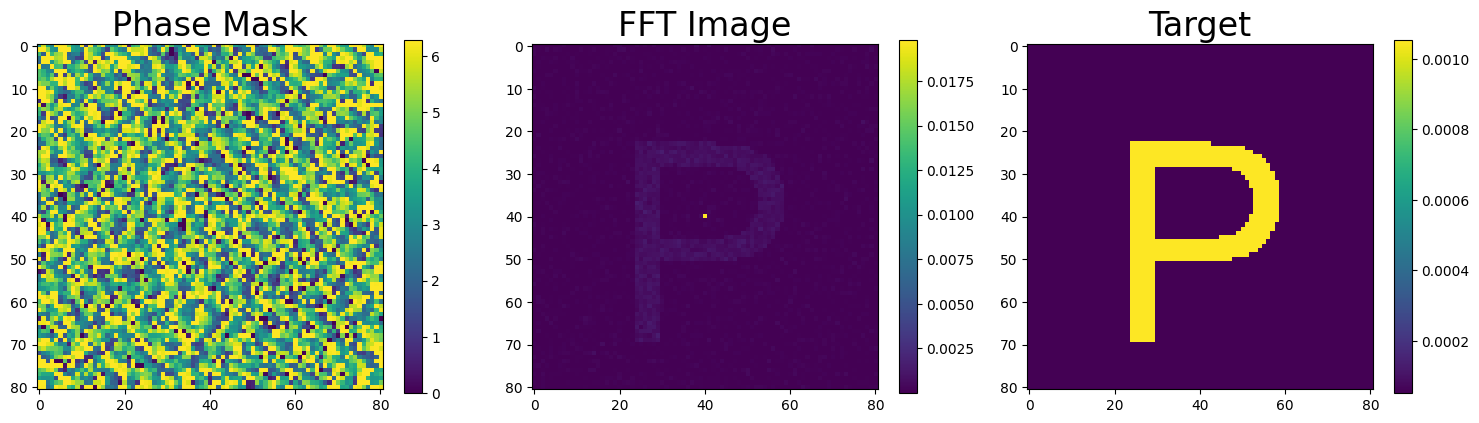

In [70]:
Final_Adam = To_Phase(final_Adam)
Aerial = Imaging(Final_Adam)
Field = Model(Final_Adam)

Show_Image(Final_Adam, Aerial, target)

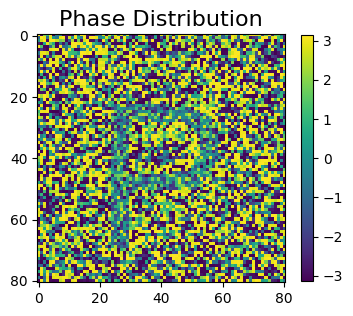

In [81]:
plt.figure(figsize = (4, 4))
plt.title('Phase Distribution', fontsize = 16)
plt.imshow(torch.angle(Field).cpu().detach().numpy())
plt.colorbar(shrink = 0.8)

### Cross Section

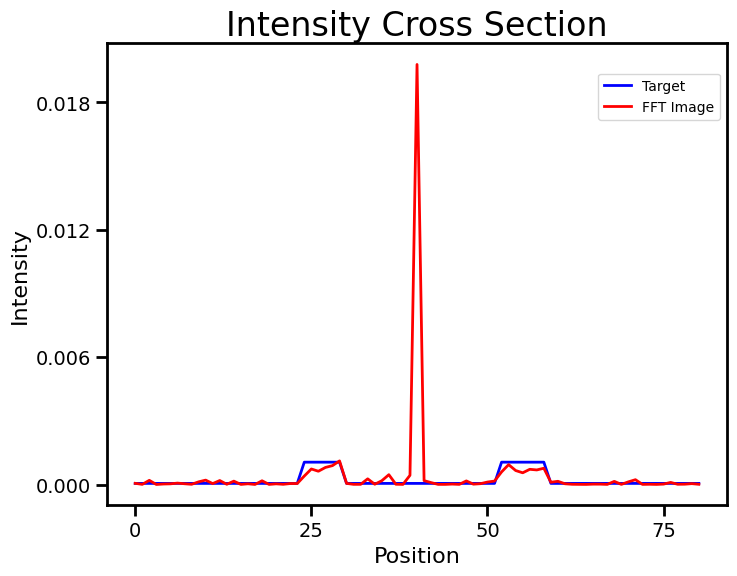

In [71]:
B = 2

fig, axes = plt.subplots(figsize = (8,6))
axes.yaxis.set_major_locator(MaxNLocator(4)) 
axes.xaxis.set_major_locator(MaxNLocator(4))    

TK = plt.gca()
TK.spines['bottom'].set_linewidth(B)
TK.spines['top'].set_linewidth(B)
TK.spines['right'].set_linewidth(B)
TK.spines['left'].set_linewidth(B)
plt.tick_params(which = 'major', width = B, length = 8)
plt.tick_params(which = 'minor', width = B, length = 5)

axes.tick_params(axis="x", labelsize=14)
axes.tick_params(axis="y", labelsize=14)

axes.set_xlabel('Position', fontsize = 16)
axes.set_ylabel('Intensity', fontsize = 16)

plt.title('Intensity Cross Section', fontsize = 24)

plt.plot(target[target.shape[0]//2,:].cpu().numpy(), linewidth = 2, color = 'blue', label = 'Target')
plt.plot(Aerial[Aerial.shape[0]//2,:].cpu().detach().numpy(), linewidth = 2, color = 'red', label = 'FFT Image')
plt.legend(prop = {'size':10}, bbox_to_anchor=(1, 0.95))

# Dynamic Modification
<img src="Figure/Dynamic_block.png"     alt="Process Flow">

If you are using Intensity Approach, you may find that the Output results is not that good engough, the one possible reason is becsuse the gradient vanishing, so we need to use a Dynamic block to do the modification

## Analyize the Loss function adjusting

In [91]:
import itertools

def grid_search(params, target, thresholds, scale_factors, n_epochs = 500):
    best_imp = 0
    best_params = None
    best_threshold = None
    best_scale_factor = None

    Map = torch.zeros((len(thresholds), len(scale_factors)))
    index_x = 0
    index_y = 0
    with tqdm(total = len(thresholds) * len(scale_factors)) as pbar_train:
        for threshold, scale_factor in itertools.product(thresholds, scale_factors):
            set_seed()
            Initial = random_tensor(x, y, device = DEVICE)
            params = Initial.clone().detach().requires_grad_(True)
            optimizer = optim.Adam([params], lr=learning_rate)
            
            # Modify dynamic_scaling function to use current threshold and scale_factor
            def dynamic_scaling(Intensity_diff, scale_factor, threshold):
                max_diff = torch.max(Intensity_diff.clone())
                if max_diff <= 10**threshold:
                    Intensity_diff *= 10**scale_factor
                return Intensity_diff
            
            # Redefine the loss function with dynamic scaling
            def loss_fn(Input, Target, Approach='Intensity'):
                # Get Amplitude ,Phase and Intensity from Input Field
                Input_amp = torch.abs(Input)
                Input_phase = torch.angle(Input)
                Input_intensity = Input_amp**2
                
                # Get Amplitude and Phase from Target
                Target_amp = abs(torch.sqrt(Target))
                Target_phase = torch.zeros_like(Target)
                Target_phase[torch.where(Target == torch.min(Target))] = torch.pi

                ## Difference
                # Calculate the amplitude difference
                Amplitude_diff = abs(Target_amp - Input_amp) ** 2
                Amplitude_diff = dynamic_scaling(Amplitude_diff, scale_factor, threshold)

                # Calculate the phase difference
                Phase_diff = torch.abs(abs(Input_phase) - Target_phase)
                Phase_diff = dynamic_scaling(Phase_diff, scale_factor, threshold)

                # Calculate the intensity difference
                Intensity_diff = torch.abs(Target - Input_intensity) ** 2
                Intensity_diff = dynamic_scaling(Intensity_diff, scale_factor, threshold)
                
                ### Loss
                Amplitude_loss = Amplitude_diff.sum()
                Phase_loss = Phase_diff.mean()
                Intensity_loss = Intensity_diff.sum()

                if Approach == 'Intensity':
                    total_loss = Intensity_loss
                if Approach == 'Amplitude':
                    total_loss = Amplitude_loss
                if Approach == 'Field':
                    total_loss = Amplitude_loss + Phase_loss

                return total_loss

            def training_loop(n_epochs, optimizer, Params, Target):
                Loss = []
                for epoch in (range(1, n_epochs + 1)):
                    Input_phase = To_Phase(Params)
                    current_field = Model(Input_phase) 
                    loss = loss_fn(current_field, Target, Approach='Intensity') 
                    
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    Input_intensity = abs(current_field)**2
                    Intensity_diff = abs(Target - Input_intensity)**2
                    LOSS = Intensity_diff.sum()

                    if epoch == 1:
                        initial = LOSS.cpu().detach().numpy()

                    if epoch == n_epochs:
                        final = LOSS.cpu().detach().numpy()

                    Loss.append(LOSS.cpu().detach().numpy()/initial)
                return Params, (initial - final)/initial * 100
            
            # Train the model
            final_params, cost_imp = training_loop(n_epochs, optimizer, params, target)
            
            # Evaluate the final loss
            final_imp = cost_imp
            if final_imp > best_imp:
                best_imp = final_imp
                best_params = final_params
                best_threshold = 10**threshold
                best_scale_factor = 10**scale_factor

            Map[index_x, index_y] = cost_imp
            index_y+=1
            if index_y == (len(scale_factors)):
                index_x += 1
                index_y = 0
                
            pbar_train.update(1)
        
    print(f"Best loss: {best_imp}")
    print(f"Best threshold: {best_threshold}")
    print(f"Best scale factor: {best_scale_factor}")
    
    return best_params, best_imp, best_threshold, best_scale_factor, Map

# Example usage
thresholds = torch.linspace(2, -8, 10)
scale_factors = torch.linspace(0, 6, 10)

learning_rate = 0.1

# Assuming Initial, params, target, and Nor are defined
best_params, best_loss, best_threshold, best_scale_factor, Imp_Map = grid_search(params, target, thresholds, scale_factors)

  0%|          | 0/100 [00:00<?, ?it/s]

Best loss: 99.99992251396179
Best threshold: 2.15443542401772e-05
Best scale factor: 464.1589660644531


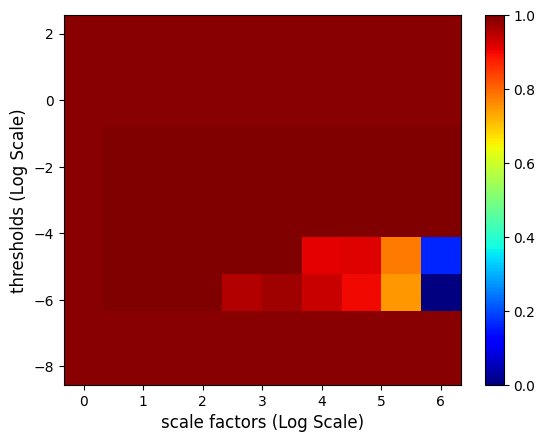

In [92]:
Modify = Imp_Map - torch.min(Imp_Map)
Modify /= torch.max(Modify)

plt.pcolormesh(scale_factors, thresholds, Modify.cpu().numpy()[:, :24], cmap = 'jet')

plt.xlabel('scale factors (Log Scale)', fontsize = 12)
plt.ylabel('thresholds (Log Scale)', fontsize = 12)
plt.colorbar()
plt.show()

## The results from the best Threshold and Scale

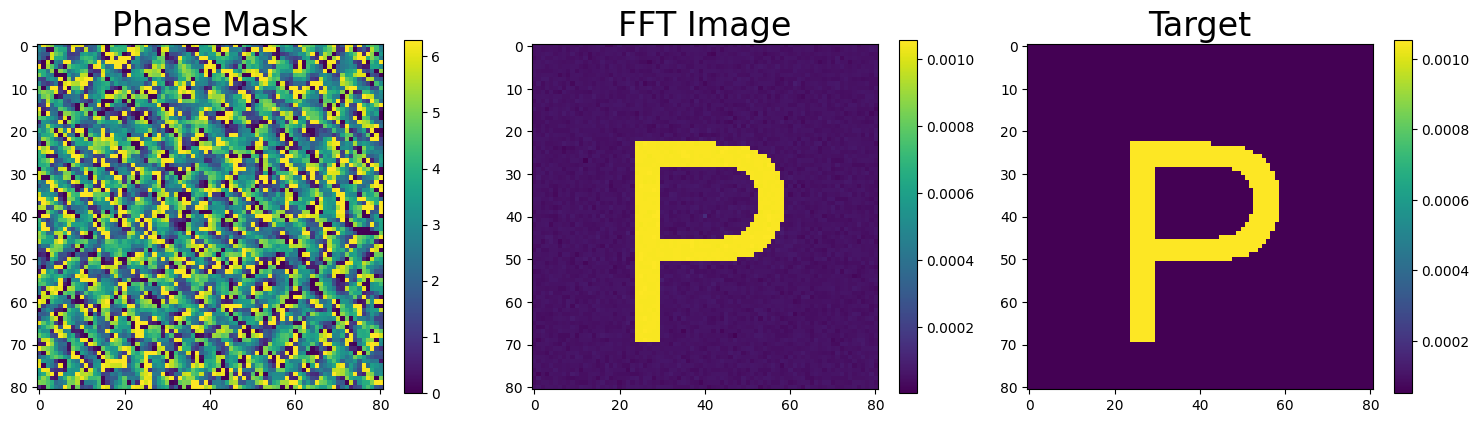

In [93]:
Final_Adam = To_Phase(best_params)
Aerial = Imaging(Final_Adam)
Field = Model(Final_Adam)
Show_Image(Final_Adam, Aerial, target)

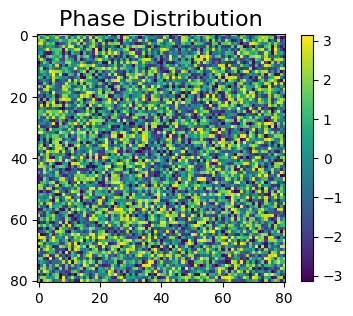

In [94]:
plt.figure(figsize = (4, 4))
plt.title('Phase Distribution', fontsize = 16)
plt.imshow(torch.angle(Field).cpu().detach().numpy())
plt.colorbar(shrink = 0.8)

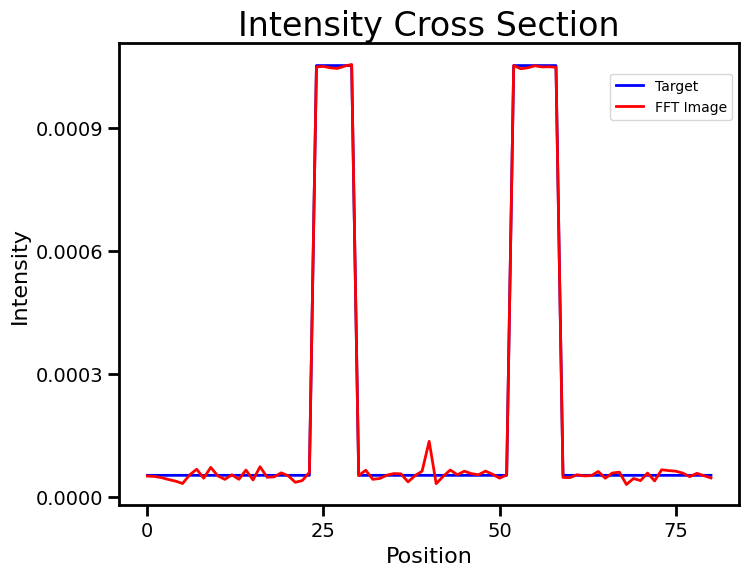

In [95]:
B = 2

fig, axes = plt.subplots(figsize = (8,6))
axes.yaxis.set_major_locator(MaxNLocator(4)) 
axes.xaxis.set_major_locator(MaxNLocator(4))    

TK = plt.gca()
TK.spines['bottom'].set_linewidth(B)
TK.spines['top'].set_linewidth(B)
TK.spines['right'].set_linewidth(B)
TK.spines['left'].set_linewidth(B)
plt.tick_params(which = 'major', width = B, length = 8)
plt.tick_params(which = 'minor', width = B, length = 5)

axes.tick_params(axis="x", labelsize=14)
axes.tick_params(axis="y", labelsize=14)

axes.set_xlabel('Position', fontsize = 16)
axes.set_ylabel('Intensity', fontsize = 16)

plt.title('Intensity Cross Section', fontsize = 24)

plt.plot(target[target.shape[0]//2,:].cpu().numpy(), linewidth = 2, color = 'blue', label = 'Target')
plt.plot(Aerial[Aerial.shape[0]//2,:].cpu().detach().numpy(), linewidth = 2, color = 'red', label = 'FFT Image')
plt.legend(prop = {'size':10}, bbox_to_anchor=(1, 0.95))